In [2]:
import numpy as np
import cv2 as cv
import random
import pandas as pd
import matplotlib.pyplot as plt
import numba
from numba import jit, cuda

%matplotlib inline

In [3]:
#Read txt file for base informations:

##Folder to read txt from
folder_name = "taipei"
"""Other Folders:
        desktop
        living_room1
        living_room2
        street
        street2
        taipei
        test
"""

##Read Exposures and insert into a numpy array
txt = pd.read_csv(f"HDR inputs/{folder_name}/image_list.txt",sep="\t",header=None)
print(f"TXT File read: {txt}")
print("   ")

##Create a numpy array for the expositions and check size
txt_array = txt[1].to_numpy()
txt_size  = len(txt_array)
explist = txt_array[1:txt_size].astype(float)

##Check number of images
num_images = txt_size - 1


##Create the log exposure array
lnexp = np.log(explist)


##Create a numpy array for the names of the images
txt_names = txt[0].to_numpy()
images_names = txt_names[1:txt_size]


print(f"Number of images ingested: {num_images}")
print("   ")
print(f"Logaritmic of expositions: {lnexp}")
print("   ")
print(f"Images names: {images_names}")

TXT File read:                0         1                2
0     # Filename  exposure  1/shutter_speed
1   DSC_0058.png        32          0.03125
2   DSC_0059.png        16           0.0625
3   DSC_0060.png         8            0.125
4   DSC_0061.png         4             0.25
5   DSC_0062.png         2              0.5
6   DSC_0063.png         1                1
7   DSC_0064.png       0.5                2
8   DSC_0065.png      0.25                4
9   DSC_0066.png     0.125                8
10  DSC_0067.png    0.0625               16
   
Number of images ingested: 10
   
Logaritmic of expositions: [ 3.4657359   2.77258872  2.07944154  1.38629436  0.69314718  0.
 -0.69314718 -1.38629436 -2.07944154 -2.77258872]
   
Images names: ['DSC_0058.png' 'DSC_0059.png' 'DSC_0060.png' 'DSC_0061.png'
 'DSC_0062.png' 'DSC_0063.png' 'DSC_0064.png' 'DSC_0065.png'
 'DSC_0066.png' 'DSC_0067.png']


Image Width:         510
Image Height:        768
Image Channels:      3
Images Array Shape:  (10, 510, 768, 3)
Quantity of images:  10


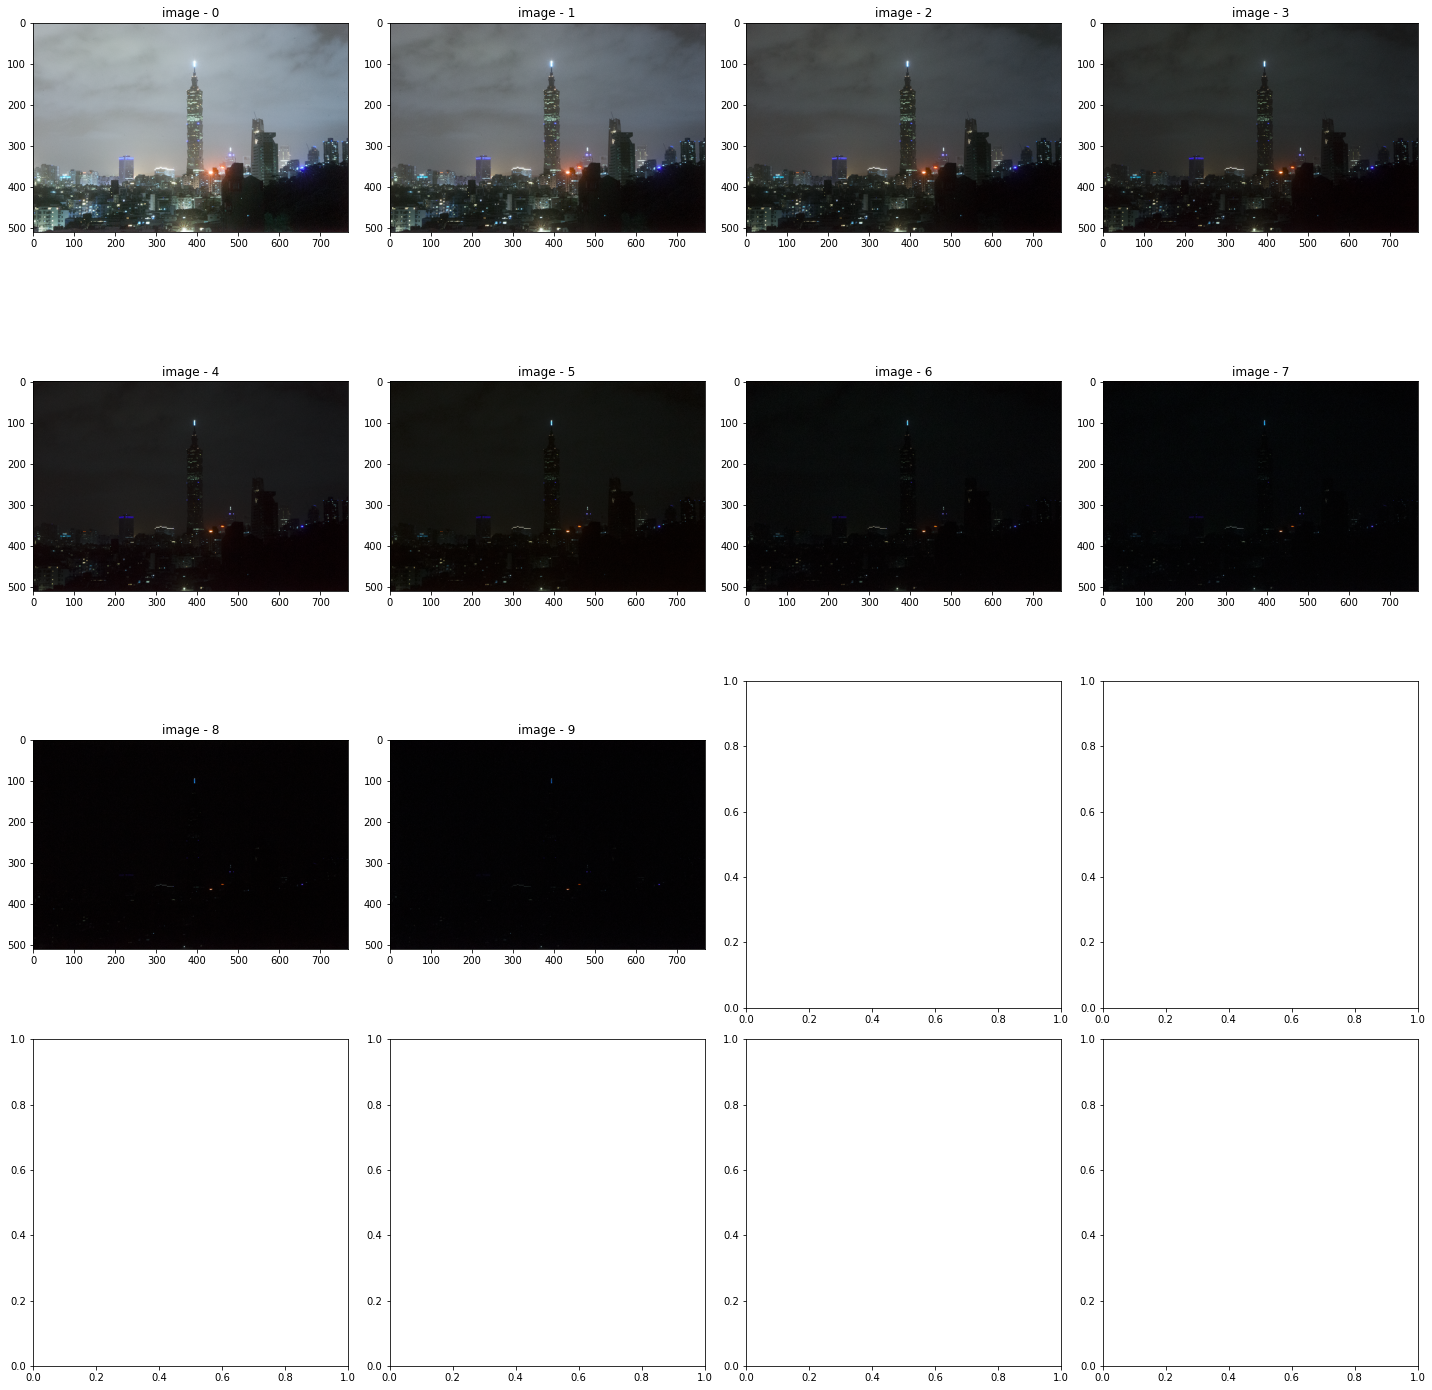

In [4]:
#Ingesting the images for the HDR

## Read one image to verify shape:
baseimg = cv.imread(f"HDR inputs/{folder_name}/{images_names[0]}")

## Test Image Atributes:
img_width    = baseimg.shape[0]
img_height   = baseimg.shape[1]
img_channels = baseimg.shape[2]


print(f"Image Width:         {img_width}")
print(f"Image Height:        {img_height}")
print(f"Image Channels:      {img_channels}")


##Create the array to receive all the images
images = np.zeros((num_images, img_width, img_height, img_channels),dtype=int) 
"""Critical point: dtype must be int, otherwise we can have a break on RGB"""

print(f"Images Array Shape:  {images.shape}")


##Ingest all images
k=0
for imgname in images_names:
    images[k] = cv.imread(f"HDR inputs/{folder_name}/{imgname}")
    k += 1

print("Quantity of images: ", images.shape[0])



##Ploting Images Array
fig, axes = plt.subplots(4,4, figsize=(20, 20))
ax = axes.ravel()
i = 0
while i < num_images:
    ax[i].imshow(images[i,])
    ax[i].set_title(f"image - {i}")
    i+=1

fig.tight_layout()
plt.show() 

In [5]:
#Flattening the images into arrays (pixels, images)
def flatten_image(images):
    """
    The idea of flattening is to go into a vectorized 
    model that will be able to calculate numbers through
    matrix multiplications.
    """

    images_flatten = images.reshape(images.shape[0],-1).T
    image_channel_size = img_width*img_height
    
    return images_flatten, image_channel_size


##--------Test-------##
images_flatten, image_channel_size = flatten_image(images)
print (f"images_flatten shape:          {images_flatten.shape}")
print (f"flat_image size per channel:   {image_channel_size}")
print (f"sanity check after reshaping:  {images_flatten[0:10,]}")
##--------Test-------##

images_flatten shape:          (1175040, 10)
flat_image size per channel:   391680
sanity check after reshaping:  [[174 108  67  36  29  18  13  10   6   3]
 [177 107  62  40  22  18   8   7   5   1]
 [181 110  60  39  21  13   6   8   4   2]
 [169 112  65  39  30  18  16   7   5   5]
 [174 111  64  38  23  20  11   4   4   3]
 [179 112  64  38  23  12  10   6   3   5]
 [175 112  72  34  34  17  19   6   4   4]
 [180 111  65  36  29  18  13   3   2   3]
 [183 114  64  35  28  10  11   5   1   4]
 [172 110  70  38  31  18  13   4   3   3]]


In [6]:
def separateChannels(images_flatten, image_channel_size): 
    images_channels = images_flatten.reshape(3,image_channel_size,10)
    rchannel = images_channels[0]
    gchannel = images_channels[1]
    bchannel = images_channels[2]
    
    return rchannel, gchannel, bchannel



##--------Test-------##
r,g,b = separateChannels(images_flatten, image_channel_size)

print(r.shape, g.shape, b.shape)
##--------Test-------##

(391680, 10) (391680, 10) (391680, 10)


In [7]:
def linearWeight(pixel_value):
    """ Linear weighting function based on pixel intensity that reduces the
    weight of pixel values that are near saturation.

    Parameters
    ----------
    pixel_value : np.uint8
        A pixel intensity value from 0 to 255

    Returns
    -------
    weight : np.float64
        The weight corresponding to the input pixel intensity

    """
    z_min, z_max = 0., 255.
    
    if pixel_value <= (0. + 255.) / 2 :
        return pixel_value - z_min
    return z_max - pixel_value


##--------Test-------##
print(f"Linear Weight of Pixel 124 at image 2:     Z={images_flatten[123,2]}     W(z)= {linearWeight(images_flatten[123,2])}")
print(f"Linear Weight of Pixel 1224 at image 3:    Z={images_flatten[1223,3]}    W(z)= {linearWeight(images_flatten[1223,3])}")
print(f"Linear Weight of Pixel 1123224 at image 6: Z={images_flatten[11223,6]} W(z)= {linearWeight(images_flatten[1123223,6])}")
##--------Test-------##

Linear Weight of Pixel 124 at image 2:     Z=67     W(z)= 67.0
Linear Weight of Pixel 1224 at image 3:    Z=51    W(z)= 51.0
Linear Weight of Pixel 1123224 at image 6: Z=7 W(z)= 10.0


In [8]:
def sampleIntensitiesFlatten(images_flatten):
    """Randomly sample pixel intensities from the exposure stack.

    Parameters
    ----------
    images : list<numpy.ndarray>
        A list containing a stack of single-channel (i.e., grayscale)
        layers of an HDR exposure stack

    Returns
    -------
    intensity_values : numpy.array, dtype=np.uint8
        An array containing a uniformly sampled intensity value from each
        exposure layer (shape = num_intensities x num_images)

    """
    z_min, z_max = 0, 255
    num_intensities = z_max - z_min + 1
    num_images = images_flatten.shape[1]
    intensity_samples = np.zeros((num_intensities, num_images), dtype=np.uint8)

    #Middle Image
    mid_img = images_flatten[:,num_images // 2]

    """
    Loop Operation:
        i operator ranges from 0 until 256, and represent the intensity values
        i_pixels picks the pixels that have the i intensity from the middle image using np.where
        
        If the i_pixels is not empty, that means we have samples to save
            pix picks a random number in the feasible pixel range that i_pixels have
            For each image:
                Pick a sample from images_flatten that have the pixel number from i_pixels[at position pix]
        
        This will generate a (255, {num_images}) array with a group of {num_images} samples, being one per
        image and intensity value.
    """
    for i in range(z_min, z_max+1):
        i_pixels = np.where(images_flatten[:,5] == i)
        if len(i_pixels[0]) != 0:
            pix = random.randrange(len(i_pixels[0]))
            for j in range(num_images):
                intensity_samples[i, j] = images_flatten[i_pixels[0][pix], j]
    return intensity_samples


##--------Test-------##
sample_intensities = sampleIntensitiesFlatten(images_flatten)
print(sample_intensities)
##--------Test-------##

[[ 69  39  25 ...   7   6   3]
 [ 34  23  15 ...   5   9   8]
 [ 18   4   3 ...   5   1   4]
 ...
 [255 255 255 ... 169 111  73]
 [255 255 255 ... 184 131  76]
 [255 254 253 ... 244 197 134]]


In [9]:
#----------------- // --------------------------#

#----------------- // --------------------------#

In [10]:
def computeResponseCurve(intensity_samples, log_exposures, smoothing_lambda, weighting_function):
    """Find the camera response curve for a single color channel

    Parameters
    ----------
    intensity_samples : numpy.ndarray
        Stack of single channel input values (num_samples x num_images)

    log_exposures : numpy.ndarray
        Log exposure times (size == num_images)

    smoothing_lambda : float
        A constant value used to correct for scale differences between
        data and smoothing terms in the constraint matrix -- source
        paper suggests a value of 100.

    weighting_function : callable
        Function that computes a weight from a pixel intensity

    Returns
    -------
    numpy.ndarray, dtype=np.float64
        Return a vector g(z) where the element at index i is the log exposure
        of a pixel with intensity value z = i (e.g., g[0] is the log exposure
        of z=0, g[1] is the log exposure of z=1, etc.)
    """
    z_min, z_max = 0, 255
    intensity_range = 255  # difference between min and max possible pixel value for uint8
    num_samples = intensity_samples.shape[0]
    num_images = len(log_exposures)

    # NxP + [(Zmax-1) - (Zmin + 1)] + 1 constraints; N + 256 columns
    mat_A = np.zeros((num_images * num_samples + intensity_range, num_samples + intensity_range + 1), dtype=np.float64)
    mat_b = np.zeros((mat_A.shape[0], 1), dtype=np.float64)

    # 1. Add data-fitting constraints:
    k = 0
    for i in range(num_samples):
        for j in range(num_images):
            z_ij = intensity_samples[i, j]
            w_ij = weighting_function(z_ij)
            mat_A[k, z_ij] = w_ij
            mat_A[k, (intensity_range + 1) + i] = -w_ij
            mat_b[k, 0] = w_ij * log_exposures[j]
            k += 1

    # 2. Add smoothing constraints:
    for z_k in range(z_min + 1, z_max):
        w_k = weighting_function(z_k)
        mat_A[k, z_k - 1] = w_k * smoothing_lambda
        mat_A[k, z_k    ] = -2 * w_k * smoothing_lambda
        mat_A[k, z_k + 1] = w_k * smoothing_lambda
        k += 1

    # 3. Add color curve centering constraint:
    mat_A[k, (z_max - z_min) // 2] = 1

    # 4. Solve through Sigular Value Decomposition (SVD)
    pinv_A = np.linalg.pinv(mat_A) #Compute the Moore-Penrose pseudo-inverse ( UEV.t => V Eˆ-1 U.t)
    x = np.dot(pinv_A, mat_b) #Find the best X through x˜= Aˆ† b   >>> A = UEV_t , Ax = b => UEV_tx = b  =>  x˜= V Eˆ-1 U_t b => x˜= Aˆ† b

    g = x[0: intensity_range + 1] #through SVD, g is the best function to minimize the squared error
    return g[:, 0]

##------- test ------##
response_curve = computeResponseCurve(sample_intensities, lnexp, 100., linearWeight)
print(response_curve)
##------- test ------##

[-4.88768540e+00 -4.75436646e+00 -4.62104752e+00 -4.48808929e+00
 -4.35582146e+00 -4.22533224e+00 -4.09704751e+00 -3.97194523e+00
 -3.84998725e+00 -3.73168091e+00 -3.61800804e+00 -3.50983164e+00
 -3.40750718e+00 -3.31135283e+00 -3.22085203e+00 -3.13558570e+00
 -3.05523823e+00 -2.97978367e+00 -2.90870237e+00 -2.84148899e+00
 -2.77755761e+00 -2.71632320e+00 -2.65720511e+00 -2.59988819e+00
 -2.54424068e+00 -2.49015000e+00 -2.43764742e+00 -2.38674658e+00
 -2.33757099e+00 -2.29030144e+00 -2.24516631e+00 -2.20199477e+00
 -2.16055660e+00 -2.12066897e+00 -2.08221691e+00 -2.04495892e+00
 -2.00873928e+00 -1.97344133e+00 -1.93905189e+00 -1.90549647e+00
 -1.87274820e+00 -1.84073217e+00 -1.80925887e+00 -1.77822833e+00
 -1.74765418e+00 -1.71739156e+00 -1.68726107e+00 -1.65726063e+00
 -1.62734995e+00 -1.59749231e+00 -1.56777795e+00 -1.53821832e+00
 -1.50890263e+00 -1.47989729e+00 -1.45122321e+00 -1.42296252e+00
 -1.39515917e+00 -1.36779948e+00 -1.34094522e+00 -1.31465356e+00
 -1.28908243e+00 -1.26429

In [11]:
def computeRadianceMap(images, log_exposure_times, response_curve, weighting_function):
    """Calculate a radiance map for each pixel from the response curve.

    Parameters
    ----------
    images : list
        Collection containing a single color layer (i.e., grayscale)
        from each image in the exposure stack. (size == num_images)

    log_exposure_times : numpy.ndarray
        Array containing the log exposure times for each image in the
        exposure stack (size == num_images)

    response_curve : numpy.ndarray
        Least-squares fitted log exposure of each pixel value z

    weighting_function : callable
        Function that computes the weights

    Returns
    -------
    numpy.ndarray(dtype=np.float64)
        The image radiance map (in log space)
    """
    img_shape = images[0].shape
    img_rad_map = np.zeros(img_shape, dtype=np.float64)
    num_images = len(images)
    
    for i in range(img_shape[0]):
        for j in range(img_shape[1]):
            g = np.array([response_curve[images[k][i, j]] for k in range(num_images)])
            w = np.array([weighting_function(images[k][i, j]) for k in range(num_images)])
            SumW = np.sum(w)
            if SumW > 0:
                img_rad_map[i, j] = np.sum(w * (g - log_exposure_times) / SumW)
            else:
                img_rad_map[i, j] = g[num_images // 2] - log_exposure_times[num_images // 2]
    return img_rad_map


In [12]:
##------- Under Construction Part 1 ------##
weighting_function = linearWeight

log_exposure_times = lnexp
img_shape = r[:,0].shape
img_rad_map = np.zeros(r.shape, dtype=np.float64)
num_images = r.shape[1]

g = np.zeros((r.shape))
w = np.zeros((r.shape))

for i in range(r.shape[0]):
    for k in range(num_images):
        g[i,k] = np.array([response_curve[r[i,k]]])
        w[i,k] = np.array([weighting_function(r[i,k])])
    #SumW = np.sum(w)
    #if SumW > 0:
    #    img_rad_map[i] = np.sum(w * (g - log_exposure_times) / SumW)
    #else:
    #    img_rad_map[i] = g[num_images // 2] - log_exposure_times[num_images // 2]

##------- Under Construction Part 1 ------##
##------- test ------##

#img_rad_map.shape
##------- test ------##

In [ ]:
##------- Under Construction Part 2 ------##
#img_rad_map = np.matmul(w,np.matmul(np.subtract(g,lnexp),np.linalg.inv(w)))
#sub = np.subtract(g,lnexp)
#first_mult = np.matmul(np.matmul(sub, w.T)

#return img_rad_map
##------- Under Construction Part 2 ------##

##------- test ------##

U, Sigma, Vt = np.linalg.svd(w)

##------- test ------##


In [ ]:
def globalToneMapping(image, gamma):
    """Global tone mapping using gamma correction
    ----------
    images : <numpy.ndarray>
        Image needed to be corrected
    gamma : floating number
        The number for gamma correction. Higher value for brighter result; lower for darker
    Returns
    -------
    numpy.ndarray
        The resulting image after gamma correction
    """
    image_corrected = cv2.pow(image/255., 1.0/gamma)
    return image_corrected

In [ ]:
def intensityAdjustment(image, template):
    """Tune image intensity based on template
        ----------
        images : <numpy.ndarray>
            image needed to be adjusted
        template : <numpy.ndarray>
            Typically we use the middle image from image stack. We want to match the image
            intensity for each channel to template's
        Returns
        -------
        numpy.ndarray
            The resulting image after intensity adjustment
        """
    m, n, channel = image.shape
    output = np.zeros((m, n, channel))
    for ch in range(channel):
        image_avg, template_avg = np.average(image[:, :, ch]), np.average(template[:, :, ch])
        output[..., ch] = image[..., ch] * (template_avg / image_avg)

    return output

In [ ]:
def unflatten_images(images_flatten):
    #Unflatten images
    img_channels = 3  #considering we will have only RGBs
    images_flatten_t = images_flatten.T
    images_unflatten = images_flatten_t.reshape(num_images, img_width, img_height, img_channels)
    
    return images_unflatten



##-------Test--------##
images_unflatten = unflatten_images(images_flatten)
print (f"images_unflatten shape: {images_unflatten.shape}")

##Ploting images_unflatten Array
fig, axes = plt.subplots(4,4, figsize=(20, 20))
ax = axes.ravel()
i = 0
while i < num_images:
    ax[i].imshow(images_unflatten[i,])
    ax[i].set_title(f"image - {i}")
    i+=1

fig.tight_layout()
plt.show()
##-------Test--------##

In [ ]:
def computeHDR(images, log_exposure_times, smoothing_lambda=100., gamma=0.6):
    """Computational pipeline to produce the HDR images
    ----------
    images : list<numpy.ndarray>
        A list containing an exposure stack of images
    log_exposure_times : numpy.ndarray
        The log exposure times for each image in the exposure stack
    smoothing_lambda : np.int (Optional)
        A constant value to correct for scale differences between
        data and smoothing terms in the constraint matrix -- source
        paper suggests a value of 100.
    Returns
    -------
    numpy.ndarray
        The resulting HDR with intensities scaled to fit uint8 range
    """

    num_channels = images[0].shape[2]
    hdr_image = np.zeros(images[0].shape, dtype=np.float64)

    for channel in range(num_channels):
        # Collect the current layer of each input image from the exposure stack
        layer_stack = [img[:, :, channel] for img in images]

        # Sample image intensities
        intensity_samples = sampleIntensities(layer_stack)

        # Compute Response Curve
        response_curve = computeResponseCurve(intensity_samples, log_exposure_times, smoothing_lambda, linearWeight)

        # Build radiance map
        img_rad_map = computeRadianceMap(layer_stack, log_exposure_times, response_curve, linearWeight)

        # Normalize hdr layer to (0, 255)
        img_rad_map_out = np.zeros_like(img_rad_map)
        cv2.normalize(img_rad_map, img_rad_map_out, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)
        hdr_image[..., channel] = img_rad_map_out
        
    # Global tone mapping
    image_mapped = globalToneMapping(hdr_image, gamma)

    # Adjust image intensity based on the middle image from image stack
    template = images[len(images)//2]
    image_tuned = intensityAdjustment(image_mapped, template)

    # Output image
    output = np.zeros_like(image_tuned)
    cv2.normalize(image_tuned, output, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)
    return output.astype(np.uint8)